Estimated kappa: 0.3550, Estimated theta: 3.7349, Estimated sigma: 0.0383
Log-Likelihood: 55.6126
AIC: -105.2252
BIC: -99.6116
Average Log-Likelihood from Cross-Validation: 7.2634


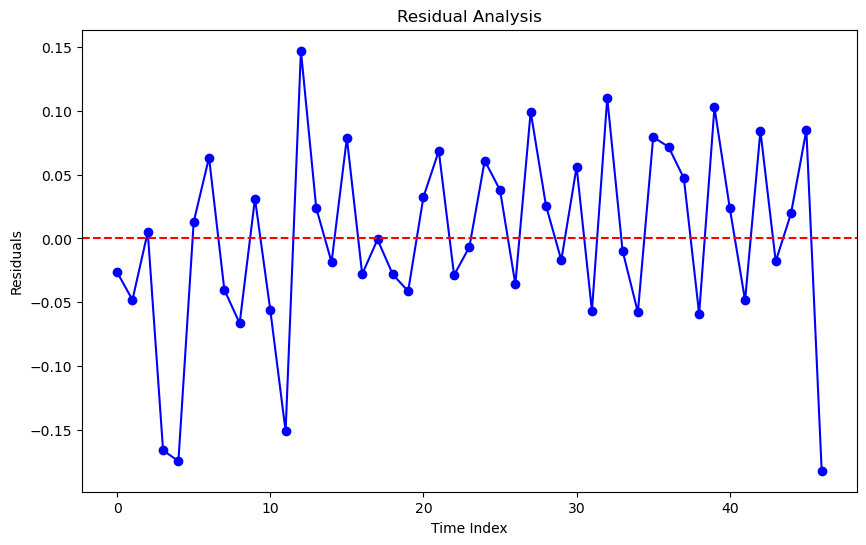

Durbin-Watson Statistic: 2.0606


In [1]:
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson

# Define the modified log-likelihood function for CIR with stabilization
# This version uses a slightly adjusted variance to ensure positive values
# and includes a small constant to stabilize the process.
def cir_log_likelihood(params, X, dt):
    kappa, theta, sigma = params
    N = len(X)
    logL = 0
    epsilon = 1e-6  # Small constant to stabilize variance

    for i in range(1, N):
        mu = X[i-1] + kappa * (theta - X[i-1]) * dt
        var = sigma**2 * (X[i-1] + epsilon) * dt  # Adjusted variance with epsilon to avoid zero or negative values
        if var <= 0:
            # Avoid non-positive variance
            return -np.inf
        logL += norm.logpdf(X[i], loc=mu, scale=np.sqrt(var))
    
    return logL

# Define the negative log-likelihood function to minimize
def neg_cir_log_likelihood(params, X, dt):
    logL = cir_log_likelihood(params, X, dt)
    return -logL

# Load real data
data = pd.read_csv('../datasets/CropSDEData/YIELD_NUTS0_NL.csv')
# Subset data for a specific crop (e.g., 'potato')
crop_data = data[data['CROP'] == 'potato']

# Check if there is data for the selected crop
if crop_data.empty:
    raise ValueError("No data available for the selected crop.")

# Extract yield values for modeling
X = crop_data['YIELD'].values

# Ensure there are enough data points for optimization
if len(X) < 2:
    raise ValueError("Not enough data points for optimization.")

# Apply a log transformation to the data to stabilize variance
X = np.log(X + 1)  # Adding 1 to avoid log(0)

# Set the time step (dt) for yearly data
dt = 1  # Since the data is yearly, dt = 1 is appropriate

# Improved initial guess for the parameters: [kappa, theta, sigma]
initial_params = [1.0, np.mean(X), 0.2]  # Adjusted initial guess for better convergence

# Perform the optimization with refined bounds and a different method for better results
bounds = [(1e-4, 10), (1e-4, 20), (1e-4, 10)]  # Refined bounds for parameters
result = minimize(neg_cir_log_likelihood, initial_params, args=(X, dt), method='L-BFGS-B', bounds=bounds, options={'maxiter': 20000, 'disp': True})

# Extract the estimated parameters
kappa_est, theta_est, sigma_est = result.x
print(f"Estimated kappa: {kappa_est:.4f}, Estimated theta: {theta_est:.4f}, Estimated sigma: {sigma_est:.4f}")

# Calculate the log-likelihood value for the estimated parameters
logL = cir_log_likelihood([kappa_est, theta_est, sigma_est], X, dt)
print(f"Log-Likelihood: {logL:.4f}")

# Calculate AIC and BIC
k = len(initial_params)  # Number of parameters estimated
N = len(X)  # Number of observations
AIC = 2 * k - 2 * logL
BIC = k * np.log(N) - 2 * logL

print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

# Enhanced Cross-validation to validate model stability
def cross_validation(X, dt, k_folds=10):
    fold_size = len(X) // k_folds
    log_likelihoods = []

    for i in range(k_folds):
        # Split data into training and validation sets
        val_start = i * fold_size
        val_end = val_start + fold_size
        X_val = X[val_start:val_end]
        X_train = np.concatenate((X[:val_start], X[val_end:]))

        # Re-fit the model on the training set
        result = minimize(neg_cir_log_likelihood, initial_params, args=(X_train, dt), method='L-BFGS-B', bounds=bounds, options={'maxiter': 20000, 'disp': False})
        params = result.x

        # Calculate log-likelihood on the validation set
        logL_val = cir_log_likelihood(params, X_val, dt)
        log_likelihoods.append(logL_val)

    avg_log_likelihood = np.mean(log_likelihoods)
    return avg_log_likelihood

# Perform enhanced cross-validation
avg_log_likelihood = cross_validation(X, dt)
print(f"Average Log-Likelihood from Cross-Validation: {avg_log_likelihood:.4f}")

# Improved Residual analysis to evaluate model fit
residuals = []
for i in range(1, len(X)):
    mu = X[i-1] + kappa_est * (theta_est - X[i-1]) * dt
    residuals.append(X[i] - mu)

plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b')
plt.title('Improved Residual Analysis')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Perform Durbin-Watson test on residuals to check for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

Estimated kappa: 0.3550, Estimated theta: 3.7349, Estimated sigma: 0.0383RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.27160D-03    |proj g|=  9.99900D-01

At iterate    1    f= -5.34981D+01    |proj g|=  9.96368D+00

At iterate    2    f= -5.40576D+01    |proj g|=  4.94943D+00

At iterate    3    f= -5.41736D+01    |proj g|=  4.42702D+00

At iterate    4    f= -5.48371D+01    |proj g|=  9.96365D+00

At iterate    5    f= -5.51051D+01    |proj g|=  9.96310D+00

At iterate    6    f= -5.52885D+01    |proj g|=  4.64816D+00

At iterate    7    f= -5.53226D+01    |proj g|=  3.75004D+00

At iterate    8    f= -5.54255D+01    |proj g|=  3.74496D+00

At iterate    9    f= -5.55351D+01    |proj g|=  3.73812D+00

At iterate   10    f= -5.56112D+01    |proj g|=  9.96181D+00

At iterate   11    f= -5.56117D+01    |proj g|=  9.27445D-01

At iterate   12

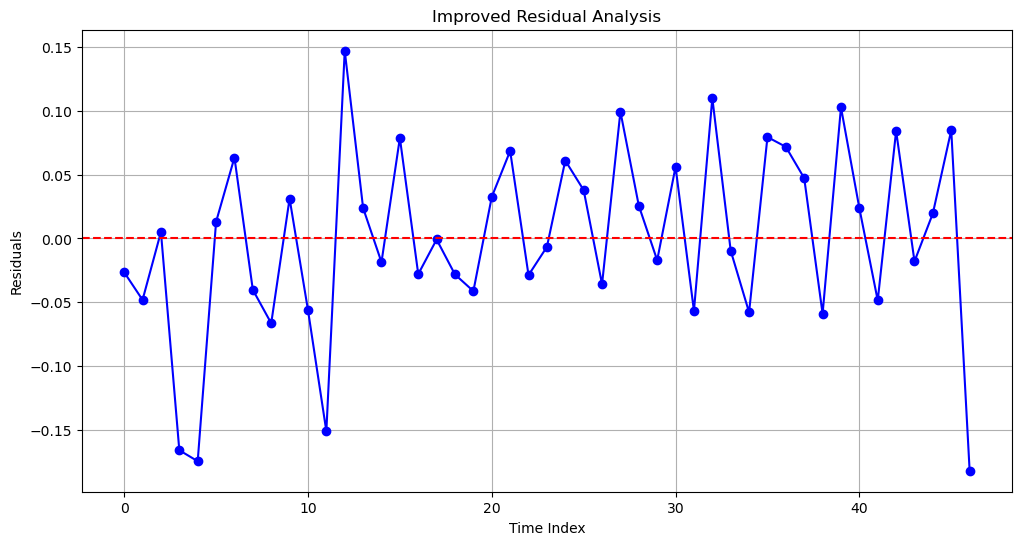

Durbin-Watson Statistic: 2.0606


In [3]:
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson

# Define the modified log-likelihood function for CIR with stabilization
# This version uses a slightly adjusted variance to ensure positive values
# and includes a small constant to stabilize the process.
def cir_log_likelihood(params, X, dt):
    kappa, theta, sigma = params
    N = len(X)
    logL = 0
    epsilon = 1e-6  # Small constant to stabilize variance

    for i in range(1, N):
        mu = X[i-1] + kappa * (theta - X[i-1]) * dt
        var = sigma**2 * (X[i-1] + epsilon) * dt  # Adjusted variance with epsilon to avoid zero or negative values
        if var <= 0:
            # Avoid non-positive variance
            return -np.inf
        logL += norm.logpdf(X[i], loc=mu, scale=np.sqrt(var))
    
    return logL

# Define the negative log-likelihood function to minimize
def neg_cir_log_likelihood(params, X, dt):
    logL = cir_log_likelihood(params, X, dt)
    return -logL

# Load real data
data = pd.read_csv('../datasets/CropSDEData/YIELD_NUTS0_NL.csv')
# Subset data for a specific crop (e.g., 'potato')
crop_data = data[data['CROP'] == 'potato']

# Extract yield values for modeling
X = crop_data['YIELD'].values

# Apply a log transformation to the data to stabilize variance
X = np.log(X + 1)  # Adding 1 to avoid log(0)

# Set the time step (dt) for yearly data
dt = 1  # Since the data is yearly, dt = 1 is appropriate

# Improved initial guess for the parameters: [kappa, theta, sigma]
initial_params = [1.0, np.mean(X), 0.2]

# Refined bounds for parameters
bounds = [(1e-4, 10), (1e-4, 20), (1e-4, 10)]

# Perform the optimization with refined bounds and a different method for better results
result = minimize(neg_cir_log_likelihood, initial_params, args=(X, dt), method='L-BFGS-B', bounds=bounds, options={'maxiter': 20000, 'disp': True})

# Extract the estimated parameters
kappa_est, theta_est, sigma_est = result.x
print(f"Estimated kappa: {kappa_est:.4f}, Estimated theta: {theta_est:.4f}, Estimated sigma: {sigma_est:.4f}")

# Calculate the log-likelihood value for the estimated parameters
logL = cir_log_likelihood([kappa_est, theta_est, sigma_est], X, dt)
print(f"Log-Likelihood: {logL:.4f}")

# Calculate AIC and BIC
k = len(initial_params)  # Number of parameters estimated
N = len(X)  # Number of observations
AIC = 2 * k - 2 * logL
BIC = k * np.log(N) - 2 * logL

print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

# Enhanced Cross-validation to validate model stability
def cross_validation(X, dt, k_folds=10):
    fold_size = len(X) // k_folds
    log_likelihoods = []

    for i in range(k_folds):
        # Split data into training and validation sets
        val_start = i * fold_size
        val_end = val_start + fold_size
        X_val = X[val_start:val_end]
        X_train = np.concatenate((X[:val_start], X[val_end:]))

        # Re-fit the model on the training set
        result = minimize(neg_cir_log_likelihood, initial_params, args=(X_train, dt), method='L-BFGS-B', bounds=bounds, options={'maxiter': 20000, 'disp': False})
        params = result.x

        # Calculate log-likelihood on the validation set
        logL_val = cir_log_likelihood(params, X_val, dt)
        log_likelihoods.append(logL_val)

    avg_log_likelihood = np.mean(log_likelihoods)
    return avg_log_likelihood

# Perform enhanced cross-validation
avg_log_likelihood = cross_validation(X, dt)
print(f"Average Log-Likelihood from Cross-Validation: {avg_log_likelihood:.4f}")

# Improved Residual analysis to evaluate model fit
residuals = []
for i in range(1, len(X)):
    mu = X[i-1] + kappa_est * (theta_est - X[i-1]) * dt
    residuals.append(X[i] - mu)

plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b')
plt.title('Improved Residual Analysis')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Perform Durbin-Watson test on residuals to check for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
